In [17]:
%load_ext autoreload
%autoreload

import sys
from os import path
sys.path.append(path.dirname(path.dirname(sys.path[1])))

from arch.MnistConvNet import MnistConvNet
from arch.sensitivity.GDNet import GDNet, AdditiveGDNet
from arch.sensitivity.BDNet import BDNet
from exp.loaddata_utils import load_mnist_one_image
import torch
from torch.autograd import Variable
import exp.utils_visualise as utils_visualise
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mnist_compare_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# %load parse_args_mnist
import argparse
import torch

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--dropout', type=str, default='gauss',
                    help='choose from ["gauss", "bern", "add_gauss"]')
parser.add_argument('--batch-size', type=int, default=256, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--estop_num', type=int, default=-1,
                    help='early stopping at which number of alpha. Default as None')
parser.add_argument('--clip_max', type=int, default=100,
                    help='Clip at which number')
parser.add_argument('--vis_method', type=str, default='log_alpha',
                    help='By loss or log_alpha')
parser.add_argument('--epochs', type=int, default=1000, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--ard_init', type=float, default=-6.,
                    help='ARD initialization')
parser.add_argument('--reg-coef', type=float, default=0.01,
                    help='regularization coefficient')
parser.add_argument('--no-cuda', action='store_false', default=True,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--epoch-print', type=int, default=10,
                    help='how many epochs to wait before logging training status')
parser.add_argument('--edge', type=int, default=4,
                    help='Output edge*edge grid of images samples')
parser.add_argument('--save-dir', type=str, default='figs/',
                    help='Save directory')
parser.add_argument('--save-tag', type=str, default='0721-gauss',
                    help='Unique tag for output images')

args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)

args.cuda = not args.no_cuda and torch.cuda.is_available()
print 'cuda:', args.cuda

cuda: False


## Test Gaussian dropout and get aupr

In [2]:
input_size = (28, 28)
trained_classifier = torch.load('../../arch/pretrained/mnist.model')

net = GDNet(input_size, trained_classifier, ard_init=args.ard_init,
              lr=args.lr, reg_coef=args.reg_coef, rw_max=30, cuda_enabled=args.cuda,
              estop_num=args.estop_num, clip_max=args.clip_max,
            )

In [3]:
img_loader = load_mnist_one_image(img_index=None, batch_size=args.batch_size, cuda=args.cuda)
net.fit(img_loader, epochs=args.epochs, epoch_print=args.epoch_print)

epoch 9 / 1000: loss 0.00012 (0.00006, 0.00006), acc 1.00, range: (-5.98, -5.93, -5.91)
epoch 19 / 1000: loss 0.00026 (0.00006, 0.00021), acc 1.00, range: (-5.88, -5.82, -5.81)
epoch 29 / 1000: loss 0.00040 (0.00006, 0.00034), acc 1.00, range: (-5.77, -5.70, -5.69)
epoch 39 / 1000: loss 0.00047 (0.00006, 0.00041), acc 1.00, range: (-5.64, -5.58, -5.57)
epoch 49 / 1000: loss 0.00046 (0.00006, 0.00041), acc 1.00, range: (-5.52, -5.46, -5.44)
epoch 59 / 1000: loss 0.00046 (0.00006, 0.00040), acc 1.00, range: (-5.41, -5.34, -5.33)
epoch 69 / 1000: loss 0.00045 (0.00006, 0.00039), acc 1.00, range: (-5.30, -5.23, -5.22)
epoch 79 / 1000: loss 0.00044 (0.00006, 0.00039), acc 1.00, range: (-5.19, -5.13, -5.11)
epoch 89 / 1000: loss 0.00044 (0.00006, 0.00038), acc 1.00, range: (-5.10, -5.02, -5.01)
epoch 99 / 1000: loss 0.00043 (0.00006, 0.00037), acc 1.00, range: (-5.00, -4.92, -4.90)
epoch 109 / 1000: loss 0.00042 (0.00006, 0.00037), acc 1.00, range: (-4.91, -4.82, -4.80)
epoch 119 / 1000: los

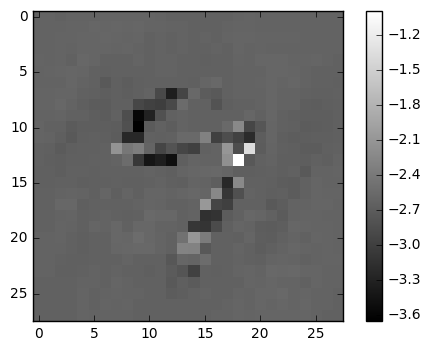

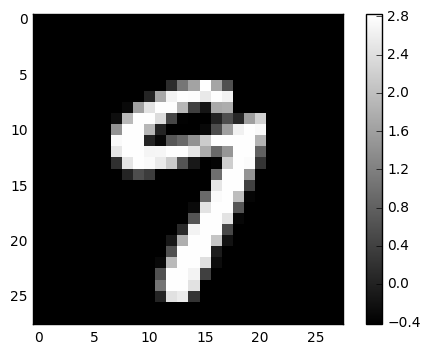

In [16]:
rank = net.get_param().data
images, labels = iter(img_loader).next()

def plot_the_img(img, cmap='gray'):
    im = plt.imshow(img, cmap=cmap, interpolation='nearest')
    plt.colorbar(im)
    plt.show()

plot_the_img(rank.numpy())
plot_the_img(images[0, 0, ...].numpy(), cmap='gray')

In [10]:
reload(mnist_compare_utils)

# Take out one mnist image and unnormalize it

logodds = mnist_compare_utils.calculate_logodds_diff_by_flipping(
    trained_classifier, images[0, ...], labels[0], rank, flip_val=(-0.1307 / 0.3081))

num_flip: 784
Variable containing:
1.00000e-02 *
 -1.4393
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
 -4.4545
[torch.FloatTensor of size 1]

Variable containing:
-0.1018
[torch.FloatTensor of size 1]

Variable containing:
-0.2668
[torch.FloatTensor of size 1]

Variable containing:
-0.4822
[torch.FloatTensor of size 1]

Variable containing:
-0.7369
[torch.FloatTensor of size 1]

Variable containing:
-0.9296
[torch.FloatTensor of size 1]

Variable containing:
-1.3876
[torch.FloatTensor of size 1]

Variable containing:
-1.2817
[torch.FloatTensor of size 1]

Variable containing:
-0.7832
[torch.FloatTensor of size 1]

Variable containing:
-1.5151
[torch.FloatTensor of size 1]

Variable containing:
-0.7843
[torch.FloatTensor of size 1]

Variable containing:
-0.2562
[torch.FloatTensor of size 1]

Variable containing:
-0.1179
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
 -5.0977
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
 -2.34

In [8]:
logodds

[4.233808517456055,
 3.0889065265655518,
 2.2338967323303223,
 1.185064673423767,
 0.4786037504673004,
 -0.08565413951873779,
 -0.4275105595588684,
 -1.1003738641738892,
 -0.9565211534500122,
 -0.17263764142990112,
 -1.2669636011123657,
 -0.17473864555358887,
 1.2311533689498901,
 2.07857608795166,
 2.950788736343384,
 3.742337226867676,
 4.344952583312988,
 4.215567588806152,
 3.6400439739227295,
 3.330636739730835,
 3.568675994873047,
 3.020630121231079,
 3.403555154800415,
 3.4637913703918457,
 3.4113006591796875,
 2.611760377883911,
 2.920348882675171,
 2.36724591255188,
 3.200381278991699,
 2.448815107345581,
 2.2651877403259277,
 2.2745885848999023,
 1.8522893190383911,
 1.6458399295806885,
 1.3772616386413574,
 1.6178526878356934,
 1.240723967552185,
 1.2106513977050781,
 0.6124737858772278,
 0.10141235589981079,
 -0.049728333950042725,
 0.2702966332435608,
 -0.32373571395874023,
 -0.18098986148834229,
 -0.4918060004711151,
 -0.22023743391036987,
 -0.032844603061676025,
 -0.0328

In [6]:
def plot_results(img1, img2, img1_title, img2_title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    im = ax1.imshow(img1, cmap='gray', interpolation='nearest')
    plt.colorbar(im)
    plt.title(img1_title)
    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(img2, cmap='gray', interpolation='nearest')
    plt.colorbar(im2)
    plt.title(img2_title)

    # filename = '%s/%s_debug.png' % (args.save_dir, args.save_tag)
    plt.show()
    # plt.savefig(filename, dpi=300)
    # plt.close()

In [7]:
orig_img = images[0, 0, ...].numpy()


plot_results(orig_img, flip_img, str(orig_log_odd), str(flip_log_odd))

NameError: name 'orig_img' is not defined